In [1]:
%pip install PyniteFEA[all]
%pip install Pynite
%pip install trimesh


   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ----------- ---------------------------- 3.4/12.3 MB 18.3 MB/s eta 0:00:01
   ----------------------- ---------------- 7.1/12.3 MB 18.9 MB/s eta 0:00:01
   ---------------------------------- ----- 10.7/12.3 MB 18.1 MB/s eta 0:00:01
   ---------------------------------------- 12.3/12.3 MB 17.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 12.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/821.6 kB ? eta -:--:--
   --------------------------------------- 821.6/821.6 kB 11.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/4.9 MB ? eta -:--:--
   ------------------------- -------------- 3.1/4.9 MB 15.4 MB/s eta 0:00:01
   ---------------------------------------- 4.9/4.9 MB 14.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.2 MB ? eta -:--:--
   -------------- --------

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 7.8 MB/s eta 0:00:00
  Created wheel for Pynite: filename=pynite-1.4.2-py3-none-any.whl size=3754 sha256=7dd8f24ff1a2135832240d9d35b52b28800be1ef0704ac7e36d09076b898bc5b
  Stored in directory: c:\users\legion\appdata\local\pip\cache\wheels\cf\b0\a5\2d5af2541abe8814dd4964515ef23e17687e8250c196c22096
Successfully built Pynite
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


PyNite Script for Multi-Span Steel Frame with Uniform Slab Loads
To model a simple steel frame (multi-span beam) supporting a concrete slab, we can use the PyNite FEA library in Python. The following script lets you define multiple spans and members, apply uniform Dead Load (DL) and Live Load (LL) on all beams (simulating slab weight and live load), and then analyze the structure under the standard 1.2 DL + 1.6 LL load combination.

In [3]:
# Import the FEModel3D class from PyNite
from Pynite.FEModel3D import FEModel3D

# Initialize a new 3D finite element model
model = FEModel3D()


Define Material and Section Properties
Next, define the material (steel) and cross-section properties for the beams. Here we use typical properties for structural steel.

In [4]:
# --- Material properties (Steel) ---
# Users can edit these values if using a different material or units.
E = 210e6   # Young's modulus in kN/m^2 (≈210 GPa, typical for steel)
nu = 0.3    # Poisson's ratio (steel ~0.3)
G = E / (2 * (1 + nu))  # Shear modulus in kN/m^2
rho = 77.0e-6  # Density in kN/m^3 (approx 77 kN/m^3, not critical unless self-weight is used)

# Add steel material to the model (name, E, G, nu, rho)
model.add_material('Steel', E, G, nu, rho)

# --- Cross-section properties for the steel beams ---
# Users can edit these to match a specific beam section (A: area, Iy/Iz: moments of inertia, J: torsional constant).
A  = 0.02      # Cross-sectional area in m^2 (example value)
Iy = 8.3e-6    # Moment of inertia about local y-axis (m^4) - e.g., weak axis
Iz = 4.2e-5    # Moment of inertia about local z-axis (m^4) - e.g., strong axis (vertical bending axis)
J  = 1.0e-5    # Torsional constant (m^4) - resistance to twisting

# Add the section properties to the model
model.add_section('BeamSection', A, Iy, Iz, J)


'BeamSection'

Define Geometry: Nodes and Members (Spans)

In [5]:
# --- Define span lengths (in meters) ---
# EDIT HERE: Modify this list to change the number of spans and their lengths.
span_lengths = [6.0, 6.0, 6.0]  # Example: three spans, each 6.0 m long

# Automatically generate node coordinates for the spans.
# We'll assume a straight horizontal beam (along global X-axis) at Y=0, Z=0 for simplicity.
current_x = 0.0
node_names = []  # to keep track of node naming
for i, L in enumerate(span_lengths):
    # Define node at the start of the span (for first span, this is the left end)
    if i == 0:
        node_name = f"N{i}"  # e.g., "N0"
        model.add_node(node_name, X=current_x, Y=0.0, Z=0.0)
        node_names.append(node_name)
    # Define node at the end of this span
    current_x += L  # advance x by the span length
    node_name = f"N{i+1}"  # e.g., "N1", "N2", ...
    model.add_node(node_name, X=current_x, Y=0.0, Z=0.0)
    node_names.append(node_name)

# Add beam members between consecutive nodes for each span
for i in range(len(span_lengths)):
    mem_name = f"M{i+1}"  # Name members as M1, M2, ...
    start_node = f"N{i}"
    end_node   = f"N{i+1}"
    # Connect the nodes with a steel beam member
    model.add_member(mem_name, i_node=start_node, j_node=end_node,
                     material_name='Steel', section_name='BeamSection', 
                     rotation=0.0)
    # (rotation=0 aligns the member's local axes with global axes by default)


Define supports at each node

In [6]:
# --- Define supports at each node ---
num_nodes = len(node_names)
for idx, node_name in enumerate(node_names):
    if idx == 0:
        # Left end support (Pinned: all translations fixed, rotations free)
        model.def_support(node_name, support_DX=True, support_DY=True, support_DZ=True,
                                      support_RX=False, support_RY=False, support_RZ=False)
    elif idx == num_nodes - 1:
        # Right end support (Roller: free in global X, fixed in vertical Y and Z; 
        # also fix torsional rotation RX for stability)
        model.def_support(node_name, support_DX=False, support_DY=True, support_DZ=True,
                                      support_RX=True, support_RY=False, support_RZ=False)
    else:
        # Intermediate supports (Pin: treat like pinned supports at column tops)
        model.def_support(node_name, support_DX=True, support_DY=True, support_DZ=True,
                                      support_RX=False, support_RY=False, support_RZ=False)


In [7]:
# --- Load cases and uniform load values ---
# EDIT HERE: Adjust the load intensities as needed (in kN/m in this example).
DL_intensity = 5.0   # Dead load (e.g. slab self-weight + finishes) in kN/m
LL_intensity = 2.5   # Live load (e.g. occupancy load) in kN/m

# Define load case names for clarity
DL_case = 'DL'
LL_case = 'LL'

# Add distributed loads to each beam member for each load case
for i, L in enumerate(span_lengths):
    mem_name = f"M{i+1}"
    # Dead Load: uniform over full span (x1=0, x2=L)
    model.add_member_dist_load(member_name=mem_name, direction="FY",
                               w1=-DL_intensity, w2=-DL_intensity, 
                               x1=0.0, x2=L, case=DL_case)
    # Live Load: uniform over full span
    model.add_member_dist_load(member_name=mem_name, direction="FY",
                               w1=-LL_intensity, w2=-LL_intensity, 
                               x1=0.0, x2=L, case=LL_case)


In [8]:
# --- Define load combination for ultimate design ---
combo_name = '1.2DL+1.6LL'
model.add_load_combo(name=combo_name, 
                     factors={DL_case: 1.2, LL_case: 1.6})


In [9]:
# --- Run linear static analysis for the defined load combination ---
model.analyze_linear(check_stability=True, check_statics=True)


+----------------+
| Statics Check: |
+----------------+

+------------------+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+-----------+----------+
| Load Combination | Sum FX | Sum RX | Sum FY | Sum RY | Sum FZ | Sum RZ | Sum MX | Sum RMX | Sum MY | Sum RMY |   Sum MZ  | Sum RMZ  |
+------------------+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+-----------+----------+
|   1.2DL+1.6LL    |   0    |   0    |  -180  |  180   |   0    |   0    |   0    |    0    |   0    |    0    | -1.62e+03 | 1.62e+03 |
+------------------+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+-----------+----------+



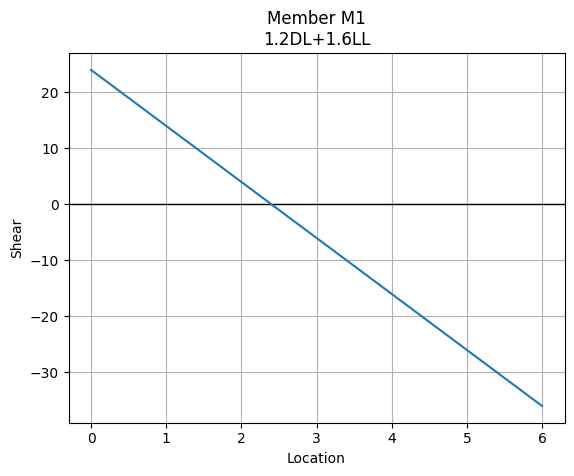

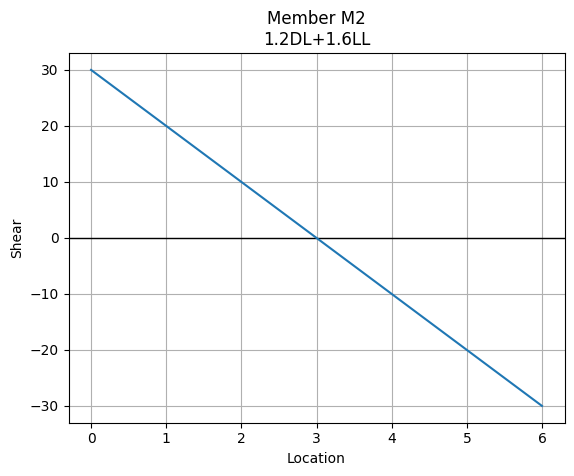

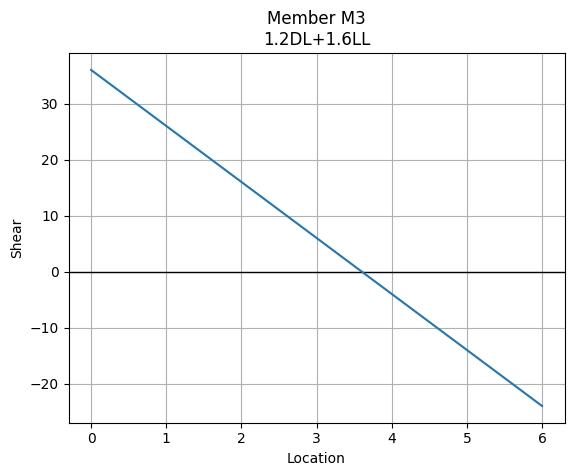

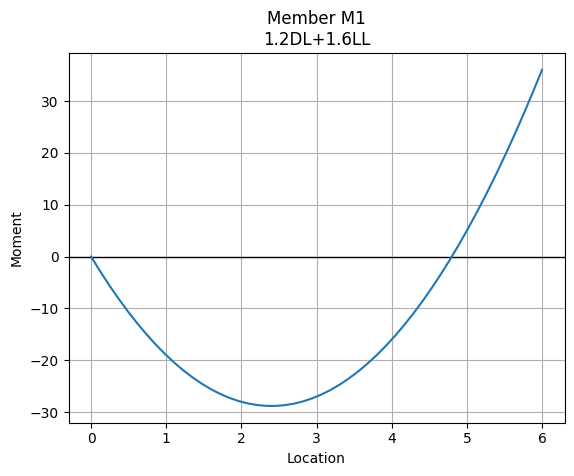

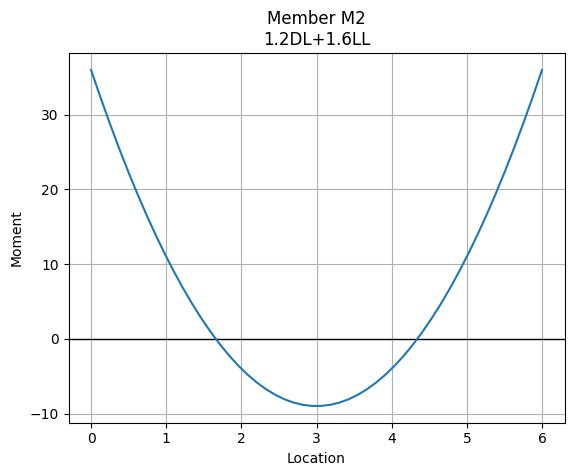

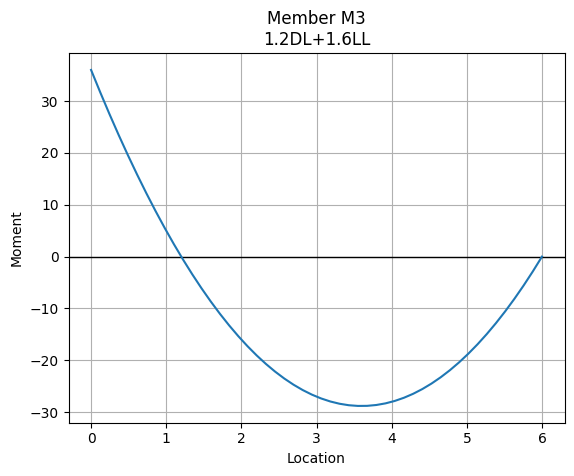

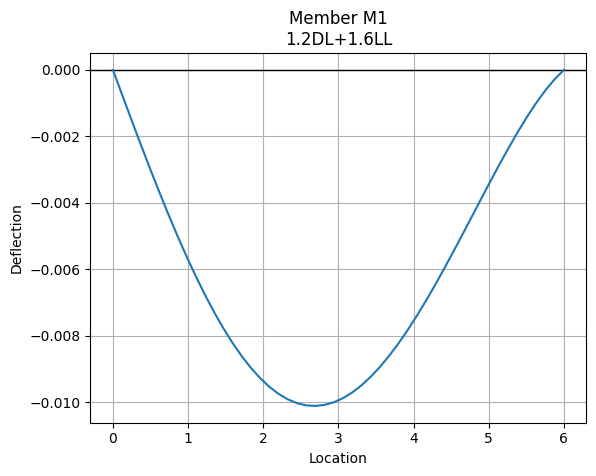

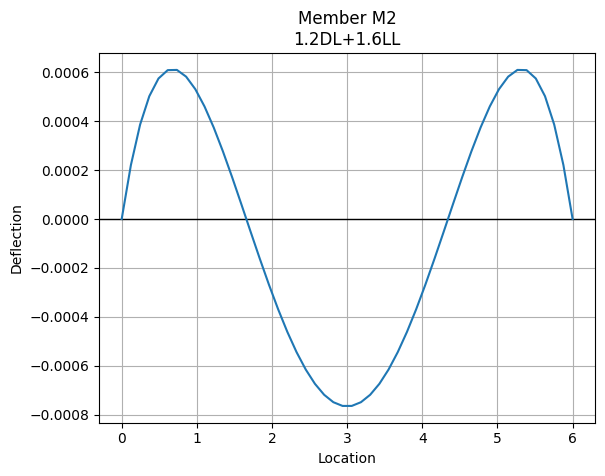

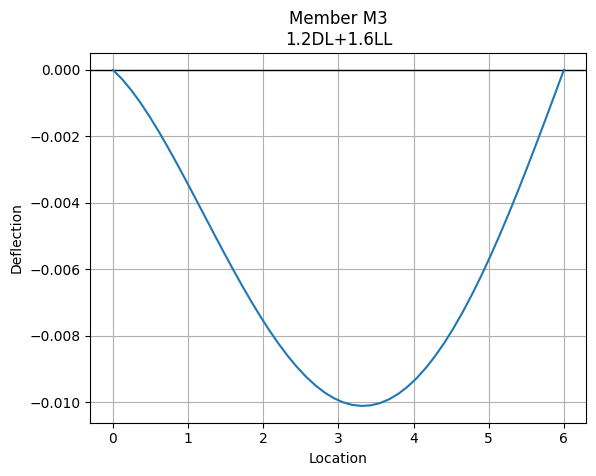

In [15]:
# Shear force diagram
for member in model.members.values():
    member.plot_shear('Fy', combo_name=combo_name, n_points=50)

# Bending moment diagram
for member in model.members.values():
    member.plot_moment('Mz', combo_name=combo_name, n_points=50)

# Deflection diagram
for member in model.members.values():
    member.plot_deflection('dy', combo_name=combo_name, n_points=50)


In [16]:
Support Reactions under combo 1.2DL+1.6LL
  Node N0:  RY = XX.XX kN
  Node N1:  RY = YY.YY kN
  Node N2:  RY = ZZ.ZZ kN
  Node N3:  RY = WW.WW kN


SyntaxError: invalid decimal literal (3645436504.py, line 1)

In [18]:
from Pynite.FEModel3D import FEModel3D

# Initialize the model
model = FEModel3D()

# Add concrete material
E = 25e6      # Concrete modulus of elasticity (kN/m²)
nu = 0.2
G = E / (2 * (1 + nu))
rho = 25      # Density in kN/m³
model.add_material('Concrete', E, G, nu, rho)

# Add beam/column section
A = 0.3 * 0.5     # Area in m² (30cm x 50cm)
Iy = (0.5 * 0.3**3) / 12  # m⁴
Iz = (0.3 * 0.5**3) / 12
J = 1e-4
model.add_section('RectBeam', A, Iy, Iz, J)

# Parameters
floors = 3
floor_height = 3.0
bays = 2
bay_length = 5.0

# Create nodes
node_names = {}
for f in range(floors + 1):
    for b in range(bays + 1):
        name = f"N{f}_{b}"
        model.add_node(name, b * bay_length, 0, f * floor_height)
        node_names[(f, b)] = name

# Add vertical columns
for f in range(floors):
    for b in range(bays + 1):
        model.add_member(f"C{f}_{b}", node_names[(f, b)], node_names[(f + 1, b)],
                         'Concrete', 'RectBeam')

# Add horizontal beams at each floor
for f in range(1, floors + 1):
    for b in range(bays):
        model.add_member(f"B{f}_{b}", node_names[(f, b)], node_names[(f, b + 1)],
                         'Concrete', 'RectBeam')

# Add fixed supports at base nodes
for b in range(bays + 1):
    model.def_support(node_names[(0, b)], True, True, True, True, True, True)

# Apply uniform loads (DL + LL) to each floor beam
DL = 10  # kN/m (slab + finishes)
LL = 5   # kN/m (live load)
for f in range(1, floors + 1):
    for b in range(bays):
        beam = f"B{f}_{b}"
        model.add_member_dist_load(beam, 'FY', -DL, -DL, 0, bay_length, 'DL')
        model.add_member_dist_load(beam, 'FY', -LL, -LL, 0, bay_length, 'LL')

# Load combination: 1.2 DL + 1.6 LL
model.add_load_combo('U1', {'DL': 1.2, 'LL': 1.6})

# Run linear static analysis
model.analyze_linear()

# Print support reactions
print("Support Reactions (Combo U1):")
for b in range(bays + 1):
    n = node_names[(0, b)]
    print(f"  Node {n}: FY = {model.nodes[n].RxnFY['U1']:.2f} kN")


Support Reactions (Combo U1):
  Node N0_0: FY = 180.13 kN
  Node N0_1: FY = 239.74 kN
  Node N0_2: FY = 180.13 kN


In [22]:
from Pynite.FEModel3D import FEModel3D

# Create the model
model = FEModel3D()

# Parameters
num_levels = 3
num_bays = 2
span = 6.0  # meters
floor_height = 3.0

# Material: Concrete
E = 25e6
G = 10e6
nu = 0.2
rho = 25e-6
model.add_material('Concrete', E, G, nu, rho)

# Sections
model.add_section('ColumnSection', 0.09, 0.002, 0.002, 0.002)
model.add_section('BeamSection', 0.15, 0.005, 0.005, 0.005)

# Nodes and members
for level in range(num_levels + 1):
    z = level * floor_height
    for bay in range(num_bays + 1):
        x = bay * span
        name = f"N{level}_{bay}"
        model.add_node(name, x, 0, z)

        if level > 0:
            below = f"N{level-1}_{bay}"
            model.add_member(f"C{level}_{bay}", below, name, 'Concrete', 'ColumnSection')

for level in range(1, num_levels + 1):
    for bay in range(num_bays):
        n1 = f"N{level}_{bay}"
        n2 = f"N{level}_{bay+1}"
        model.add_member(f"B{level}_{bay}", n1, n2, 'Concrete', 'BeamSection')

# Supports
for bay in range(num_bays + 1):
    model.def_support(f"N0_{bay}", True, True, True, True, True, True)

# Loads
DL = 3.0  # kN/m
LL = 5.0  # kN/m
for level in range(1, num_levels + 1):
    for bay in range(num_bays):
        beam = f"B{level}_{bay}"
        model.add_member_dist_load(beam, 'FY', -DL, -DL, 0, span, 'DL')
        model.add_member_dist_load(beam, 'FY', -LL, -LL, 0, span, 'LL')

# Load combo
model.add_load_combo('1.2DL+1.6LL', {'DL': 1.2, 'LL': 1.6})

# Analyze
model.analyze_linear()

# Output top node displacements
print("Top-floor vertical displacements:")
for bay in range(num_bays + 1):
    node = model.nodes[f"N{num_levels}_{bay}"]
    print(f"  Node {node.name}: {node.DY['1.2DL+1.6LL']:.4f} m")


Top-floor vertical displacements:
  Node N3_0: -0.3721 m
  Node N3_1: -0.3832 m
  Node N3_2: -0.3721 m
